In [ ]:
#make sure to enable GPU before beginning! (Edit --> Notebook settings)
!apt-get update -y
!apt-get install -y libvips libvips-dev
%pip install segment-geospatial groundingdino-py opencv-python matplotlib 'git+https://github.com/facebookresearch/segment-anything.git' pillow pyvips

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://cli.github.com/packages stable InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading packag

In [ ]:
import numpy as np
#import torch
import matplotlib.pyplot as plt
import cv2
import os
print(os.getcwd())
print(os. listdir())
!file image_test.tif #gives information on the image (check which conversions necessary)

/content
['.config', '.ipynb_checkpoints', 'sam_vit_h_4b8939.pth', 'image_test_small.png.aux.xml', 'image_test.tif', '5b320a7e2b6a08001185f88f.tif', 'image_test_small.png', 'sample_data']
image_test.tif: TIFF image data, little-endian, direntries=21, height=15128, bps=266, compression=JPEG, PhotometricIntepretation=YCbCr, width=15585


In [ ]:
###SELECT AS APPROPRIATE

#use cv2 to load image in - check 3 channel
#image = cv2.imread('image_test.tif') #change for name of file
#convert image to rgb format channels
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#sometimes with image format satellite obtain additional metadata not compatible with opencv - cannot be used with certain image types
#import rasterio as rio
#with rio.open("image_test.tif") as src:
#   image = src.read()  # (bands, height, width)

#for the case that a jpeg compression of tif is used
#from PIL import Image
#import numpy as np
#img = Image.open("image_test.tif")
#image = np.array(img.convert("RGB"))  # Convert YCbCr to RGB
#print(image.shape, image.dtype)
#image type is too large - therefore downsizing function is used (consider memory issues (GPU availability) etc)

import pyvips
import numpy as np

image_vips = pyvips.Image.new_from_file("image_test.tif", access="sequential")

# rescaling before full decoding
max_dim = 3000
scale = max_dim / max(image_vips.width, image_vips.height)
if scale < 1:
    image_vips = image_vips.resize(scale)

# Convert to numpy array
image = np.ndarray(
    buffer=image_vips.write_to_memory(),
    dtype=np.uint8,
    shape=[image_vips.height, image_vips.width, image_vips.bands],
)
print(image.shape)


Error: unable to write to memory
  image_test.tif: bad seek to 36071830
TIFFFillTile: Seek error at row 1536, col 13824, tile 806
image_test.tif: bad seek to 36075158
TIFFFillTile: Seek error at row 1536, col 13824, tile 808


In [ ]:
#in case all above approaches fail, can try directly re-formatting file before reading and save as new format
#NOTE: these are classic problems requiring a good pre-processing pipeline to read the data properly. The approach proposed here is not optimal, as it can cause corrpution/loss of metadata.
#In a real-world problem you would spend time to understand the source data format and write a script which can retain the relevant informatino

!apt-get install -y gdal-bin
!gdal_translate -outsize 3000 3000 -of PNG image_test.tif image_test_small.png


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  python3-gdal python3-numpy
Suggested packages:
  libgdal-grass python-numpy-doc python3-pytest
The following NEW packages will be installed:
  gdal-bin python3-gdal python3-numpy
0 upgraded, 3 newly installed, 0 to remove and 37 not upgraded.
Need to get 5,168 kB of archives.
After this operation, 25.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 python3-numpy amd64 1:1.21.5-1ubuntu22.04.1 [3,467 kB]
Get:2 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy/main amd64 python3-gdal amd64 3.8.4+dfsg-1~jammy0 [1,095 kB]
Get:3 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy/main amd64 gdal-bin amd64 3.8.4+dfsg-1~jammy0 [605 kB]
Fetched 5,168 kB in 5s (959 kB/s)
Selecting previously unselected package python3-numpy.
(Reading database ... 131824 files and directo

In [ ]:
#should be 3 channels and uint8
image = cv2.imread("image_test_small.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(image.shape, image.dtype)

(3000, 3000, 3) uint8


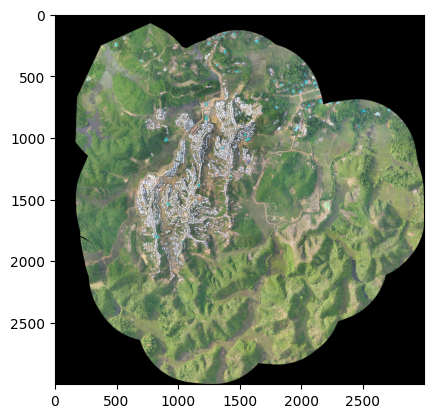

In [ ]:
plt.imshow(image)

In [ ]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
#first we try the basic SAM

#to see the functions

import requests

#load in the necessary SAM model checkpoint
url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
open("sam_vit_h_4b8939.pth", "wb").write(requests.get(url).content)


#set up the model params
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h" #note the use of "huge" model (check docs)

#consider also trying different size models to compare performance:
###Large model
#url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth"
#open("sam_vit_l_0b3195.pth", "wb").write(requests.get(url).content)
#sam_checkpoint = "sam_vit_l_0b3195.pth"
#model_type = "vit_l"
###Base model
#url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth"
#open("sam_vit_b_01ec64.pth", "wb").write(requests.get(url).content)
#sam_checkpoint = "sam_vit_b_01ec64.pth"
#model_type = "vit_b"

device = "cuda" #gpu

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)




Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [ ]:

#set up the mask generator
#play around with the parameters to see what works! Check the docs!!!!
#https://github.com/facebookresearch/segment-anything/blob/main/segment_anything/automatic_mask_generator.py

#consider looping over different values and storing the masks, so that you can compare the segmentation
#consider also cropping around relevant sections in case the number of points provides insufficient granularity
pps = 48
iou = 0.9
stable = 0.9
crop_n = 1
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=pps,
    pred_iou_thresh=iou,
    stability_score_thresh=stable,
    crop_n_layers=crop_n,
    crop_n_points_downscale_factor=crop_n,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)


#apply the mask generator func to the image
mask = mask_generator.generate(image)
print(len(mask))
print(mask[0].keys())
#NB: go through the mask keys and think about how they can be useful for the coding exercise
#distribution of scores etc. can also give an indication of where thresholds can be set


381
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [ ]:
#function for showing mask
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(mask)
plt.axis('off')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import samgeo
#using now the ability to incorporate text prompts
#NB: may crash due to GPU constraints

from samgeo.text_sam import LangSAM
print(samgeo.__version__) #check that version is recent
sam_2 = LangSAM()
#model_type = "vit_b", "vit_l", "vit_h" dependent on size of model to use (check docs)

GroundingDINO_SwinB.cfg.py: 0.00B [00:00, ?B/s]

final text_encoder_type: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

groundingdino_swinb_cogcoor.pth:   0%|          | 0.00/938M [00:00<?, ?B/s]

Downloading: "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth" to /root/.cache/torch/hub/checkpoints/sam_vit_h_4b8939.pth


100%|██████████| 2.39G/2.39G [02:18<00:00, 18.5MB/s]


In [ ]:
text_prompt = "man-made"
#alternative - think about e.g. making a prompt which finds what you DON'T want and subtract from your masks

In [ ]:
#again, suggested to play around with the prompts and parameters
#https://github.com/luca-medeiros/lang-segment-anything/blob/main/lang_sam/lang_sam.py
sam_2.predict(image="refugee_satellite.jpeg",
              text_prompt=text_prompt,
              box_threshold=0.2,
              text_threshold=0.5)

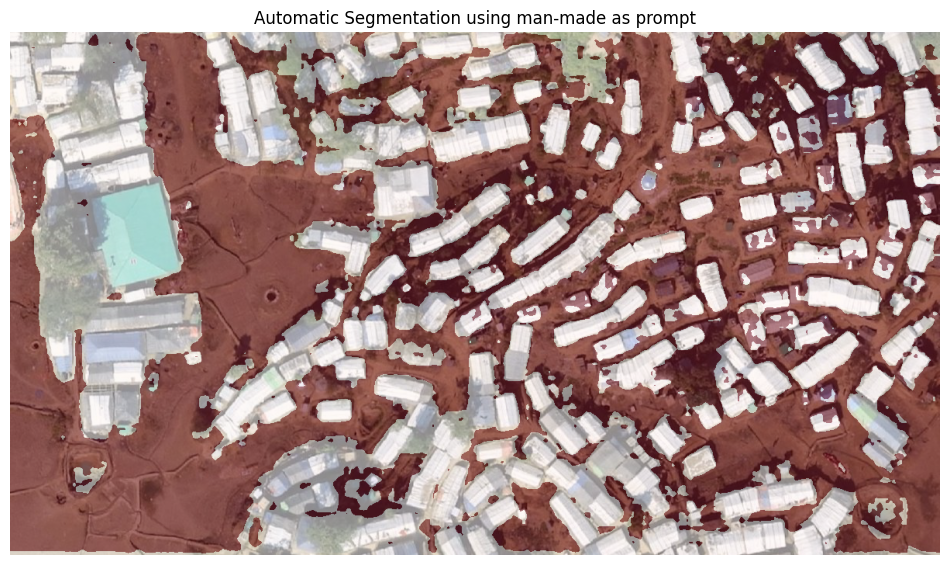

In [ ]:
sam_2.show_anns(
    cmap="Reds",
    add_boxes=False,
    alpha=0.5,
    title=f"Automatic Segmentation using {text_prompt} as prompt",
)

In [ ]:
#using the inbuilt scripts from carribean project (e.g util funcs etc)
#https://github.com/GFDRR/caribbean-rooftop-classification - see docs, used for satellite image analysis
%%capture
!git clone https://github.com/GFDRR/caribbean-rooftop-classification.git
!pip -q install -U segment-geospatial
!pip -q install -U git+https://github.com/IDEA-Research/GroundingDINO.git
!pip -q install leafmap huggingface_hub json_fix
!pip -q install --upgrade --no-cache-dir gdown
%cd caribbean-rooftop-classification
!git checkout add/tutorials

In [ ]:
import os
import gdown

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import rasterio as rio
import geopandas as gpd
import leafmap
import torch

from rasterio.plot import show
from shapely.geometry import box
from samgeo import SamGeo

import sys
sys.path.insert(0, "./")
from utils import pred_utils
#NB: with this approach - new working directory is the carribean-rooftop-classification
print(os.getcwd())

/content/caribbean-rooftop-classification


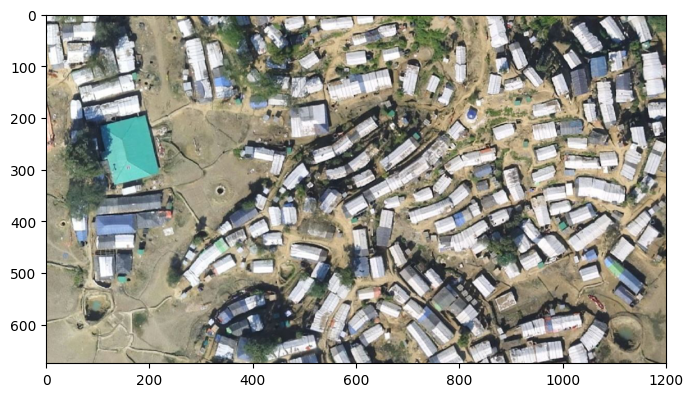

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
image_file = "../refugee_satellite.jpeg" #change to desired filepath
image = rio.open(image_file) #rio used to maintain the crs coordinate reading (geospatial reader)
show(image, ax=ax);
w = image.shape[1]
h = image.shape[0]

In [ ]:
#to use with this method, need to set coordinate system. since I haven't set up for this example,
#here are some random approximate numbers (also worth playing with to fix)
from rasterio.transform import from_origin
from rasterio.crs import CRS
from PIL import Image
import numpy as np

# Define your input image and desired physical size
w = image.shape[1]
h = image.shape[0]

w_h = w/h #ratio of width to height

X_m = 240  # width in meters - assume 100 pixels = 20m
Y_m = X_m/w_h  # height in meters

# Compute pixel size in meters
xres = X_m / w
yres = Y_m / h

# Define top-left coordinate (0, Y_m) and transform
transform = from_origin(0, Y_m, xres, yres)

# Create an artificial GeoTIFF with a fake meter-based CRS
data = np.array(Image.open(image_file))
if data.ndim == 2:  # grayscale
    data = data[np.newaxis, ...]
else:
    data = data.transpose(2, 0, 1)  # (bands, rows, cols)

new_tif = "../image_georef.tif"
with rio.open(
    new_tif,
    "w",
    driver="GTiff",
    height=h,
    width=w,
    count=data.shape[0],
    dtype=data.dtype,
    crs=CRS.from_epsg(3857),  # "meters" CRS, arbitrary local
    transform=transform,
) as dst:
    dst.write(data)

In [ ]:
#verify the new image coords
with rio.open(new_tif) as r:
    print("CRS:", r.crs)
    print("Transform:", r.transform)
    print("Bounds:", r.bounds)

CRS: EPSG:3857
Transform: | 0.20, 0.00, 0.00|
| 0.00,-0.20, 135.00|
| 0.00, 0.00, 1.00|
Bounds: BoundingBox(left=0.0, bottom=0.0, right=240.0, top=135.0)


In [ ]:
#calling in-built function of git repo,
#NB: this approach requires .crs data - i.e. a coordinate reference system

tile_size = min(w, h) #sweep over the tiles, tile_size is ts*ts
min_house = 100
max_house = 100000
for prompt in ["houses", "buildings", "tents", "shelters", "rooftops", "urban area"]:
    polygons = pred_utils.segment_image(
        image_file=new_tif,
        out_dir="../temp_dir",
        out_file="../temp_file",
        text_prompt=prompt,
        box_threshold=0.1,
        text_threshold=0.1,
        min_area=5,
        max_area=20000,
        tile_size=512,
        tolerance=0.1,
    )
    print(prompt, len(polygons)) #get number of hits, in case we are not finding anything (#DO NOT START WITH THIS - try instead a simple prompt)

final text_encoder_type: bert-base-uncased


3932160it [00:00, 584473542.30it/s]       
 47%|████▋     | 7/15 [00:27<00:29,  3.71s/it]

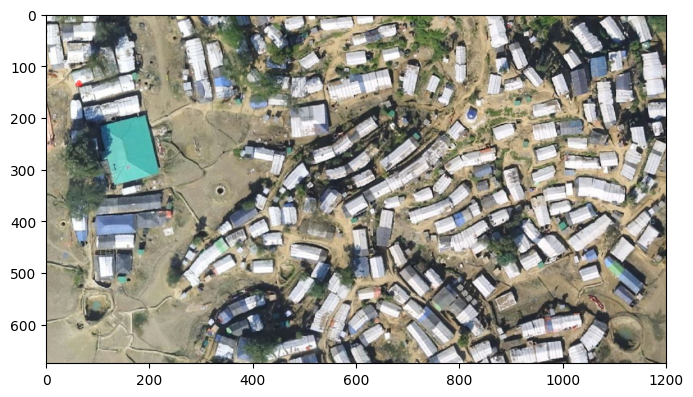

In [ ]:
color = "red"
fig, ax = plt.subplots(figsize=(8,8))
polygons.plot(facecolor=color, edgecolor=color,  linewidth=3, alpha=0.5, ax=ax, aspect=1)
show(image, ax=ax);